In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule

trans = {
    'HorizontalFlip': {'p': 0.5},
    'VerticalFlip': {'p': 0.5},
    'RandomRotate90': {'p': 0.5},
    'Transpose': {'p': 0.5},
    # 'RandomResizedCrop': {'height': 256, 'width': 256, 'scale': (0.8, 1.0), 'ratio': (0.75, 1.3333333333333333), 'p': 0.5},
}
s1_bands = (0, 1, 2, 3)
s2_bands = (2, 1, 0, 3, 4, 5, 6, 7, 8, 9)

dm = DataModule(batch_size=4, use_ndvi=True, use_ndwi=True, use_clouds=True, s1_bands=s1_bands, s2_bands=s2_bands, train_trans=trans)
dm.setup()

train: 8689
test: 2773


In [3]:
x, labels = next(iter(dm.train_dataloader()))

s1, s2 = x
s1.shape, s2.shape, s2.max(), s2.min()

(torch.Size([4, 12, 4, 256, 256]),
 torch.Size([4, 12, 13, 256, 256]),
 tensor(1.),
 tensor(0.))

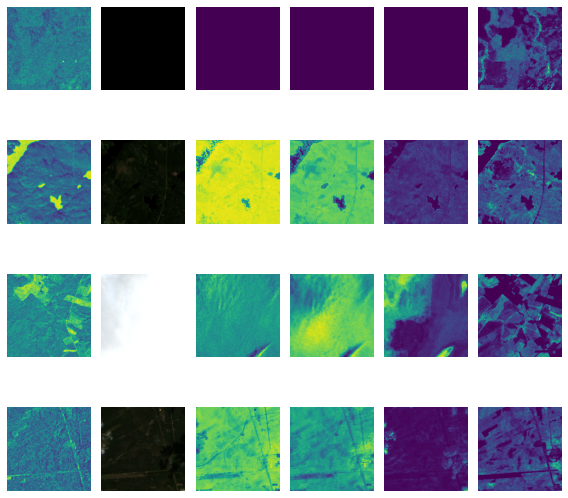

In [4]:
import matplotlib.pyplot as plt 

x, labels = next(iter(dm.train_dataloader()))
# x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 6, 6*i+1)
    ax.imshow(s1s[i][0][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 6, 6*i+2)
    ax.imshow(s2s[i][0][:3,...].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 6, 6*i+3)
    ax.imshow(s2s[i][0][-3])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 6, 6*i+4)
    ax.imshow(s2s[i][0][-2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 6, 6*i+5)
    ax.imshow(s2s[i][0][-1])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 6, 6*i+6)
    ax.imshow(labels[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from src.models.unet_ltae import UNetLTAE1

hparams = {
    'encoder': 'resnet18',
    'pretrained': None,
    'in_channels_s1': 4,
    'in_channels_s2': 13,
    'seq_len': 12,
    'n_head': 16
}

model = UNetLTAE1(hparams)

outputs = model(x)

outputs.shape

torch.Size([4, 256, 256])

In [7]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4, use_ndvi=True, use_ndwi=True, use_clouds=True, s1_bands=s1_bands, s2_bands=s2_bands)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 4,
	'in_channels_s2': 13,
	'optimizer': 'Adam',
    'seq_len': 12,
	'n_head': 16,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetLTAE1(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=300,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 3.2 M 
3 | segmentation_head | SegmentationHead | 145   
4 | ltae              | LTAE             | 1.3 M 
-------------------------------------------------------
26.8 M    Trainable params
25.6 K    Non-trainable params
26.8 M    Total params
53.597    Total estimated model params size (MB)
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloa

Training: 0it [00:00, ?it/s]

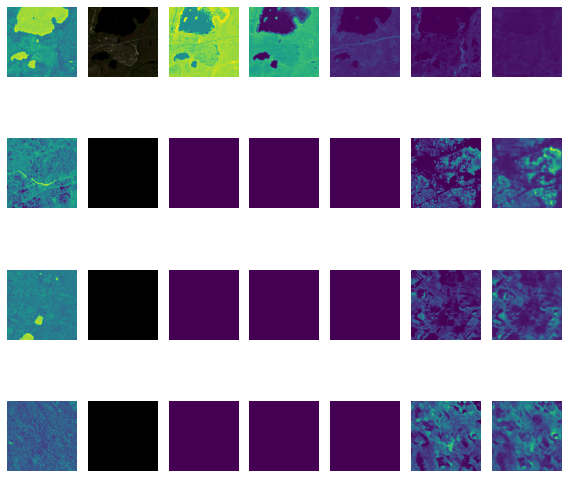

In [8]:
import matplotlib.pyplot as plt 

x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 7, 7*i+1)
    ax.imshow(s1s[i][0][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 7, 7*i+2)
    ax.imshow(s2s[i][0][:3,...].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 7, 7*i+3)
    ax.imshow(s2s[i][0][-3])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 7, 7*i+4)
    ax.imshow(s2s[i][0][-2])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 7, 7*i+5)
    ax.imshow(s2s[i][0][-1])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 7, 7*i+6)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 7, 7*i+7)
    ax.imshow(preds[i])
    ax.axis('off')
plt.tight_layout()
plt.show()